<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Read-in-and-process-data" data-toc-modified-id="Read-in-and-process-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Read in and process data</a></span><ul class="toc-item"><li><span><a href="#Read-in-normalized-read-counts-for-all-samples" data-toc-modified-id="Read-in-normalized-read-counts-for-all-samples-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Read in normalized read counts for all samples</a></span></li><li><span><a href="#Read-in-label-data-for-all-samples" data-toc-modified-id="Read-in-label-data-for-all-samples-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Read in label data for all samples</a></span></li><li><span><a href="#Combine-label-data-and-read-counts-into-one-dataframe" data-toc-modified-id="Combine-label-data-and-read-counts-into-one-dataframe-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Combine label data and read counts into one dataframe</a></span></li><li><span><a href="#Export-measured-genes-for-GO-enrichment-analysis" data-toc-modified-id="Export-measured-genes-for-GO-enrichment-analysis-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Export measured genes for GO enrichment analysis</a></span></li></ul></li><li><span><a href="#Classification" data-toc-modified-id="Classification-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Classification</a></span><ul class="toc-item"><li><span><a href="#Validation:-leave-one-out-(DEG-determination-and-feature-selection-within-loop)" data-toc-modified-id="Validation:-leave-one-out-(DEG-determination-and-feature-selection-within-loop)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Validation: leave one out (DEG determination and feature selection within loop)</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Plot results</a></span></li></ul></li><li><span><a href="#Classifier" data-toc-modified-id="Classifier-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Classifier</a></span></li><li><span><a href="#Classifier-based-on-genes-from-literature" data-toc-modified-id="Classifier-based-on-genes-from-literature-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Classifier based on genes from literature</a></span><ul class="toc-item"><li><span><a href="#Cross-validation" data-toc-modified-id="Cross-validation-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Cross validation</a></span></li><li><span><a href="#Plot-results" data-toc-modified-id="Plot-results-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Plot results</a></span></li></ul></li></ul></div>

# Imports

In [1]:
import math
import os

import boruta
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from joblib import Parallel, delayed
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.pipeline import Pipeline

# Functions

In [2]:
def log(value):
    
    if value != 0:
        return math.log(value, 2)
    else:
        return 0

def parse(value):
    
    if value.endswith('_') and 'REU1' not in value:
        return value+'M'
    else:
        return value
    
def assign_group(value):
    
    try:
        new_value = label_df.loc[label_df['name']==value, 'class_group'].values[0]
    except IndexError:
        display(value, label_df.loc[label_df['name']==value, 'class_group'])
        raise IndexError
    return new_value

def plot_colourline(x,y,c):
    
    # function to plot a line according to a third variable
    # found @ https://stackoverflow.com/questions/36505587/color-line-by-third-variable-python
    col = cm.jet((c-np.min(c))/(np.max(c)-np.min(c)))
    ax = plt.gca()
    for i in np.arange(len(x)-1):
        ax.plot([x[i],x[i+1]], [y[i],y[i+1]], c=col[i])
        #ax.annotate(str(c[i]), (x[i], y[i]))
    return ax

def map_genes(genes, key=0, target=3):
     
    '''Map genes to gene names according to gene_file.
    Maps values from column key to column target.
    Takes a list as input and returns a dict with as key, value pairs: to map gene value, mapped gene name.'''
    
    gene_file = '/Users/nicolasdeneuter/Dropbox/PhD/Projects/GOA/GEMS/original_data/genes.txt'
    gene_df = pd.read_csv(gene_file, sep='\t', header=None)

    mapped_genes = {}
    unmapped_genes = []
    for gene in genes:
        gene_mask = gene_df[key] == gene
        try:
            mapped_gene = gene_df.loc[gene_mask, target].values[0]
        except IndexError:
            unmapped_genes.append(gene)
        mapped_genes[gene] = mapped_gene
    return mapped_genes, unmapped_genes

# Read in and process data

In [3]:
maindir = '/Users/nicolasdeneuter/Dropbox/PhD/Projects/GOA/GEMS/data_paper'
readcountpath = '{}/plan_classification_samples_without_BM2/DESeq2_normalized_readcounts.txt'.format(maindir)
label_path = '{}/col_data.txt'.format(maindir)

## Read in normalized read counts for all samples

In [4]:
count_df = pd.read_csv(readcountpath)
count_df = count_df.rename(columns={'Unnamed: 0': 'genename'})
count_df = count_df.set_index('genename', drop=True)
count_df = count_df[[col for col in count_df.columns if 'UNDETERMINED' not in col]]
count_df = count_df.T
count_df.index = pd.Series(count_df.index).apply(lambda x: x.replace('.', '-'))
count_df.shape, count_df.index

((81, 22905),
 Index(['AZT11_M_S33', 'AZT13_M_S35', 'AZT14_M_S37', 'AZT15_M_S39',
        'AZT16_M_S1', 'AZT17_M_S3', 'AZT18_M_S5', 'AZT1_M_S19', 'AZT20_M_S7',
        'AZT2_M_S21', 'AZT3_M_S23', 'AZT5_M_S25', 'AZT6_M_S27', 'AZT7_M_S29',
        'AZT9_M_S31', 'DINANT12_M_S25', 'DINANT1_M_S13', 'DINANT2_M_S15',
        'DINANT3_M_S17', 'DINANT4_M_S19', 'DINANT5_M_S21', 'DINANT6_M_S23',
        'NIK3_M_S1', 'NIK7_M_S3', 'NIK8_M_S5', 'STELI1_M_S7', 'STELI2_M_S9',
        'STELI5_M_S11', 'STELI6_M_S13', 'STELI7_M_S15', 'STELI8_M_S17',
        'UZA3_M_S9', 'UZA4_M_S11', 'VJA_M_S29', 'VJB_M_S31', 'DINANT14_M_S27',
        'STA2__S35', 'STLUC1__S36', 'UZB11__S37', 'UZB12__S38', 'VJC_M_S33',
        'NIK4__S5', 'NIK6B__S7', 'NIK6__S6', 'NIK9__S8', 'STA1__S1', 'STA5__S2',
        'STA6__S3', 'UZA6__S4', 'UZB1__S9', 'UZB3__S10', 'UZB4__S11',
        'UZB9__S13', 'UZB13__S39', 'UZG1__S40', 'UZA21__S36', 'BEN-001A__S14',
        'BEN-002__S15', 'BEN-003__S16', 'BEN-006A__S17', 'BEN-008__S31',
    

## Read in label data for all samples

In [5]:
label_path = '{}/col_data.txt'.format(maindir)
label_df = pd.read_csv(label_path, sep='\t')
label_df = label_df.fillna('')
label_df.loc[:, 'name'] = label_df[['tags', 'sample_type', 'sample']].apply(lambda x: '_'.join(x), axis=1)
label_df.loc[:, 'class_group'] = label_df[['group', 'sample_type']].apply(lambda x: parse('_'.join(x)), axis=1)
label_df.shape

(82, 9)

## Combine label data and read counts into one dataframe

In [6]:
Y = pd.DataFrame(pd.Series(count_df.index).apply(lambda x: assign_group(x)), columns=['target'])
Y.index = count_df.index
df = pd.concat([Y, count_df], axis=1)
df['target'].unique()

array(['EV1_M', 'BM1_M', 'EV2_M', 'VM_M', 'PN_M', 'REU1_', 'REU2_M'],
      dtype=object)

## Export measured genes for GO enrichment analysis

In [7]:
measured_genes = [col for col in df.columns if 'gene' in col]
converted_genes, unmapped_genes = map_genes(genes=measured_genes, key=0, target=3)
print(len(measured_genes), len(set(converted_genes.values())), len(converted_genes), len(unmapped_genes))

22905 22883 22905 0


In [8]:
with open('../data_paper/measured_genes.txt', 'w') as o:
    for gene in converted_genes.values():
        o.write('{}\n'.format(gene))

# Classification
## Validation: leave one out (DEG determination and feature selection within loop)

In [9]:
loo_dir = '{}/plan_classification_samples_without_BM2'.format(maindir)

# select samples
loo_df = df[(df['target']=='EV1_M') | (df['target']=='BM1_M') | (df['target']=='EV2_M') | (df['target']=='BM2_M')]
    
def generate_inputs(loo_dir):
    
    for directory, subdirs, files in os.walk(loo_dir):
        if 'DESeq2_results_group2-EVvsBM_fold1_sig.txt' in files and directory.endswith(loo_dir) != True:
            left_out_sample = directory.split('/')[-1]
            if assign_group(left_out_sample) in loo_df['target'].unique():
                yield left_out_sample
            
    
def cross_validate(left_out_sample):
    
    results = {'sample': [],
           'true label': [],
           'pred label': [],
           'pos proba': [],
           'neg proba': []}
    
    train_samples = [sample for sample in loo_df.index if sample != left_out_sample]

    # determine DEGS
    deg_df = pd.read_csv('{}/DESeq2_results_group2-EVvsBM_fold1_sig.txt'.format(loo_dir),
                         sep='\t')

    feature_names = deg_df['Unnamed: 0'] # contains names of differentially expressed genes

    # make train set
    X_train = loo_df.loc[train_samples, feature_names]
    Y_train = loo_df.loc[train_samples, 'target'].apply(lambda x: x[:2])

    # make left out test sample
    X_test = loo_df.loc[left_out_sample, feature_names].values.reshape(1, -1)
    Y_test = loo_df.loc[left_out_sample, 'target']

    # do feature selection and train classifier
    RF = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, class_weight='balanced')
    feat_selection = boruta.BorutaPy(ExtraTreesClassifier(n_jobs=-1),
                                     n_estimators='auto',
                                     random_state=0,
                                     alpha=0.001,
                                     two_step=False)
    predictor = Pipeline([('feature_selection', feat_selection), ('classification', RF)])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        predictor.fit(X_train.values, Y_train.values)

    # do predictions on test sample and keep statistics
    neg_proba, pos_proba = predictor.predict_proba(X_test)[0]

    # report results
    importance = predictor.named_steps['classification'].feature_importances_
    for x in zip([left_out_sample], [Y_test], predictor.predict(X_test), predictor.predict_proba(X_test)):
        print(x, len(importance))
        results['sample'].append(x[0])
        results['true label'].append(x[1])
        results['pred label'].append(x[2])
        results['neg proba'].append(x[3][0])
        results['pos proba'].append(x[3][1])
    
    return Y_test, pos_proba, results


all_results = Parallel(n_jobs=8)(delayed(cross_validate)(i) for i in generate_inputs(loo_dir))

loo_class_label = [x[0] for x in all_results]
loo_pos_class_proba = [x[1] for x in all_results]
results = {}
for x in all_results:
    dct = x[2]
    for key, item in dct.items():
        results.setdefault(key, []).append(item[0])

In [10]:
results_df = pd.DataFrame(results).sort_values(by='pos proba', ascending=False)
results_df.to_csv('{}/prediction_results.txt'.format(loo_dir), sep='\t', index=False)
results_df

,sample,true label,pred label,pos proba,neg proba
52,STELI7_M_S15,EV1_M,EV,1.000,0.000
16,AZT2_M_S21,EV1_M,EV,1.000,0.000
46,UZA4_M_S11,EV1_M,EV,1.000,0.000
44,NIK8_M_S5,EV1_M,EV,1.000,0.000
50,AZT18_M_S5,EV1_M,EV,1.000,0.000
31,UZB3__S10,EV2_M,EV,1.000,0.000
30,AZT20_M_S7,EV1_M,EV,1.000,0.000
29,AZT3_M_S23,EV1_M,EV,1.000,0.000
28,DINANT6_M_S23,EV1_M,EV,1.000,0.000
27,VJA_M_S29,EV1_M,EV,1.000,0.000


## Plot results

In [11]:
fpr, tpr, thres = roc_curve([0 if x == 'BM1_M' or x == 'BM2_M' else 1 for x in loo_class_label], 
                            loo_pos_class_proba)
fpr = np.insert(fpr, 0, 0)
tpr = np.insert(tpr, 0, 0)

0.9822695035460993


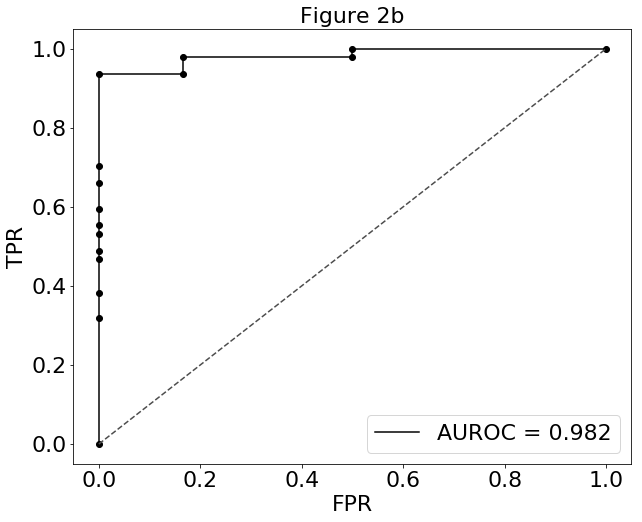

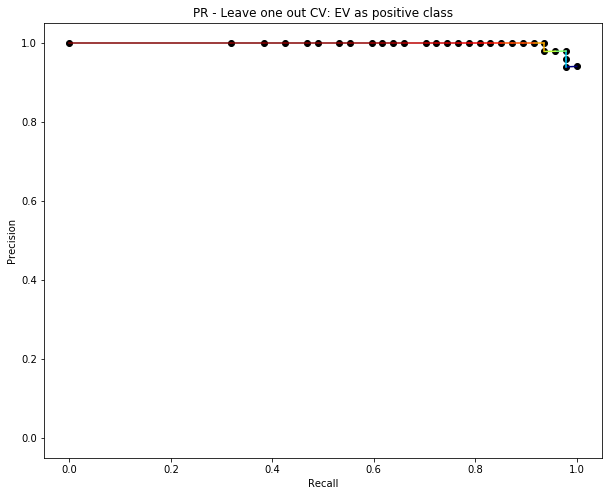

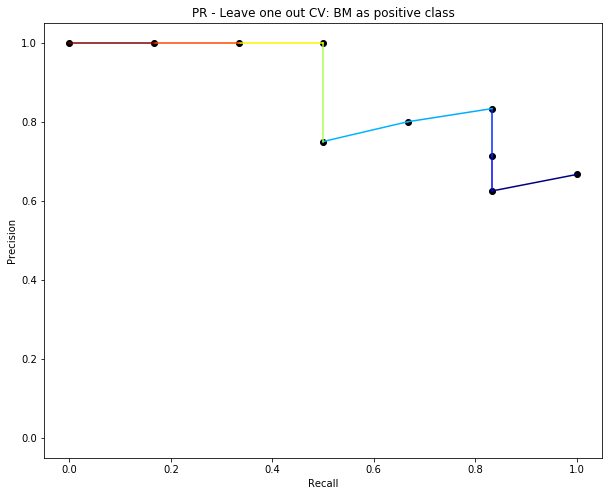

In [12]:
auroc = roc_auc_score([0 if x == 'BM1_M' or x == 'BM2_M' else 1 for x in loo_class_label], loo_pos_class_proba)
print(auroc)
fig, ax = plt.subplots(figsize=(10,8))
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
plt.scatter(fpr, tpr, c='k')
plt.title('Figure 2b', fontsize=22)
#plot_colourline(fpr, tpr, thres)
plt.plot(fpr, tpr, c='k', label='AUROC = {:.3f}'.format(auroc))
ax.plot([0, 1], [0, 1], ls="--", c=".3")
plt.legend(fontsize=22)
plt.xlabel('FPR', fontsize=22)
plt.ylabel('TPR', fontsize=22)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.savefig('{}/auc_loo.png'.format(loo_dir), dpi=600)
plt.savefig('../figures/fig2b.png'.format(loo_dir, dpi=600))
plt.show()


precision, recall, thres = precision_recall_curve([0 if x == 'BM1_M' or x == 'BM2_M'  else 1 for x in loo_class_label],
                                                  loo_pos_class_proba)
plt.subplots(figsize=(10,8))
plt.scatter(recall, precision, c='k')
plt.title('PR - Leave one out CV: EV as positive class')
plot_colourline(recall, precision, thres)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.savefig('{}/pr_EV_pos_loo.png'.format(loo_dir), dpi=600)
plt.show()

precision, recall, thres = precision_recall_curve([0 if x == 'EV1_M' or x == 'EV2_M'  else 1 for x in loo_class_label],
                                                  [1-x for x in loo_pos_class_proba])
plt.subplots(figsize=(10,8))
plt.scatter(recall, precision, c='k')
plt.title('PR - Leave one out CV: BM as positive class')
plot_colourline(recall, precision, thres)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.savefig('{}/pr_BM_pos_loo.png'.format(loo_dir), dpi=600)
plt.show()

# Classifier

In [13]:
class_dir = '{}'.format(maindir)

deg_df = pd.read_csv('{}/plan_classification_samples_without_BM2/DESeq2_results_group2-EVvsBM_fold1_sig.txt'.format(class_dir),
                     sep='\t')
feature_names = deg_df['Unnamed: 0']

class_df = df[(df['target']=='EV1_M') | (df['target']=='BM1_M') | (df['target']=='EV2_M') | (df['target']=='BM2_M')]

train_samples = class_df.index
X_train = class_df.loc[train_samples, feature_names]
Y_train = class_df.loc[train_samples, 'target'].apply(lambda x: x[:2])

RF = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, class_weight='balanced')
feat_selection = boruta.BorutaPy(ExtraTreesClassifier(n_jobs=-1),
                                 n_estimators='auto',
                                 random_state=0,
                                 alpha=0.001,
                                 two_step=False)
predictor = Pipeline([('feature_selection', feat_selection), ('classification', RF)])
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    predictor.fit(X_train.values, Y_train.values)

In [14]:
importances = np.zeros(X_train.shape[1], float)
importances[predictor.named_steps['feature_selection'].support_] =\
    predictor.named_steps['classification'].feature_importances_
len(feature_names), len(importances)

selected_features = []
for name, importance in zip(feature_names, importances):
    if importance > 0:
        print(name, importance)
        selected_features.append(name)

gene10273 0.07327813350483413
gene43161 0.014757553703881647
gene10276 0.045145062213934134
gene6684 0.06164426594008088
gene19977 0.10204269692962069
gene35336 0.055094566236604046
gene26456 0.029
gene14394 0.007881170032489795
gene4424 0.007540460799556468
gene28006 0.026619062375326397
gene20648 0.008562999638987236
gene46562 0.028946195026103877
gene17181 0.05945858677776101
gene6413 0.005076641802860604
gene12264 0.03259652789197969
gene1618 0.004958333333333334
gene11116 0.02814003401360544
gene34740 0.027512767684552842
gene2860 0.015708651458129955
gene23420 0.039298247703818845
gene24867 0.01653401881088054
gene5407 0.019876634986830344
gene48092 0.02622879088347566
gene43682 0.015053084585597534
gene42046 0.010964432284541723
gene31193 0.0159276625289291
gene3193 0.011039260220635951
gene44364 0.01803926022063595
gene12715 0.017592978085541604
gene30392 0.038788417613166655
gene35672 0.04624568134511323
gene41836 0.004211287543809506
gene45421 0.036881297542615904
gene44365 0

dict_values(['LOC101927568', 'RETN', 'EPHB1', 'INSIG2', 'SLC25A40', 'GPR68', 'NDST2', 'ANKRD34B', 'GALNT2', 'LDHA', 'LOC105375508', 'LOC102723475', 'RUNX2', 'IL1R2', 'PLAC8', 'GADD45A', 'ZDHHC19', 'PTGER2', 'S100A12', 'LDHAP4', 'FBXW2', 'COX7A2L', 'RBX1', 'NDUFA13', 'LOC105371985', 'ACVR1B', 'FCER1G', 'CD177', 'SPRY1', 'GAPDH', 'C14orf2', 'MAFG', 'TRMT6', 'LOC105372409', 'TCEB2', 'COX8A', 'EIF5A']) 37
/Users/nicolasdeneuter/Dropbox/PhD/Projects/GOA/GEMS/data_paper/plan_classification_samples_without_BM2


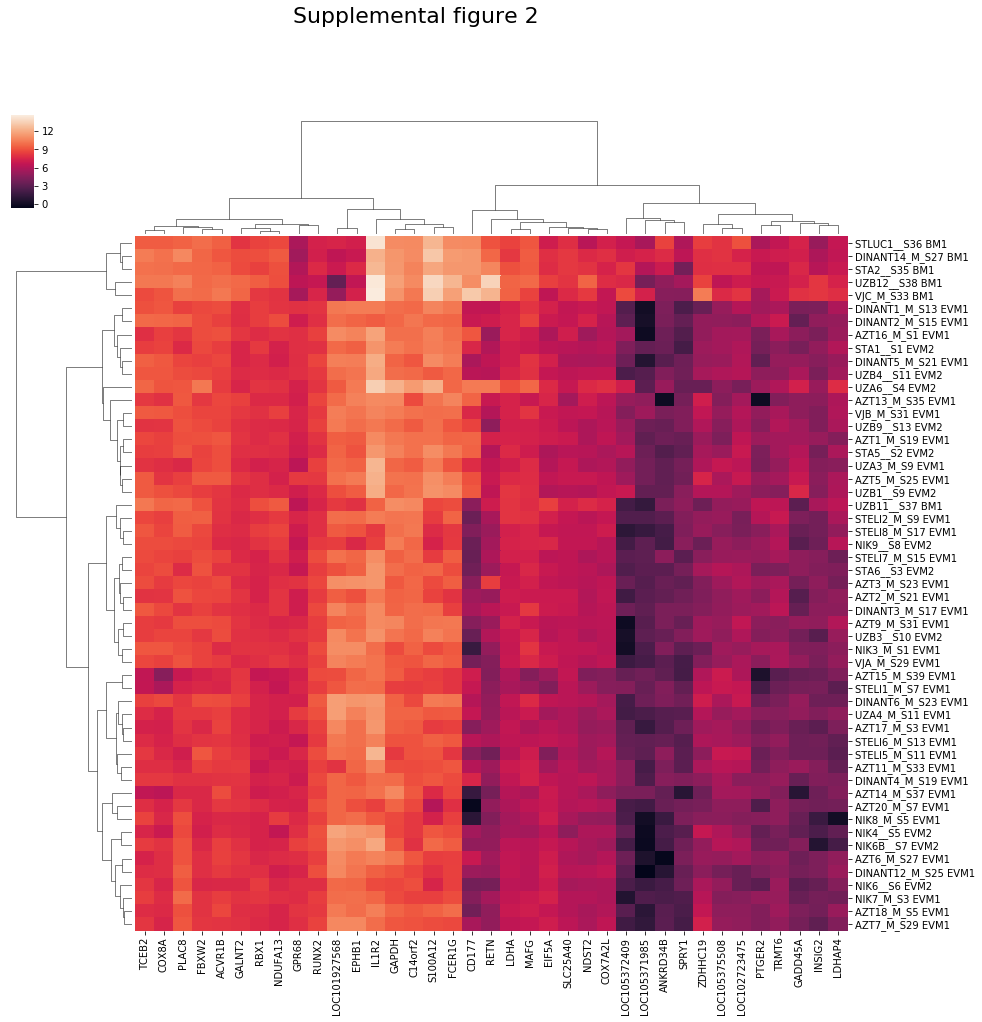

In [15]:
gene_dict, unmapped_genes = map_genes(selected_features, key=0, target=3)
print(gene_dict.values(), len(gene_dict.values()))
with open('../data_paper/plan_classification_samples_without_BM2/predictive_genes_EVM-BM.txt', 'w') as o:
    for value in gene_dict.values():
        o.write('{}\n'.format(value))

class_df.index = class_df.index + ' ' + class_df['target']

heatmap_df = class_df.loc[:, selected_features].applymap(log)
heatmap_df.index = [x.replace('BM1_M', 'BM1').replace('EV1_M', 'EVM1').replace('EV2_M', 'EVM2') for x in heatmap_df.index]
heatmap_df.columns = [gene_dict[x] for x in heatmap_df.columns]
sns.clustermap(heatmap_df, method='ward', metric='euclidean', figsize=(15, 15)).fig.suptitle('Supplemental figure 2', fontsize=22)
plt.savefig('{}/clustered_heatmap_EVMvsBMstrict.png'.format(loo_dir), dpi=600)
plt.savefig('../figures/suppfig2.png'.format(loo_dir), dpi=600)
print(loo_dir)

# Classifier based on genes from literature

In [16]:
gene_list = ['IFI27', 'IFI44L', 'IFIT1', 'RSAD2', 'IFIT3', 'IFITM3', 'OTOF', 'IFIT2', 'IFITM2', 'EPSTI1', 'SERPING',
             'SERPING1', 'OAS1', 'IFI6', 'HLA-DRB6', 'HBZ', 'HS.386275', 'EIF2AK2', 'IFIT1L', 'FCER1A', 'FCER1G',
             'C21ORF7', 'GYPE', 'GYPB', 'HBM', 'EIF1AY', 'LOC649143', 'HBD', 'FBXO7', 'KCNMA1', 'MERTK', 'EBI3', 'FAM89A',
             'UPB1', 'EMR1', 'PTPN20', 'TMEM119', 'TMEM120A', 'SLPI', 'S100P', 'PI3']
print(len(gene_list))
gene_dict, unmapped_genes = map_genes(gene_list, key=3, target=0)

41


## Cross validation

In [17]:
loo_class_label = []
loo_pos_class_proba = []
results = {'sample': [],
           'true label': [],
           'pred label': [],
           'pos proba': [],
           'neg proba': []}

loo_dir = '{}/plan_classification_samples'.format(maindir)
for directory, subdirs, files in os.walk(loo_dir):
    if 'DESeq2_results_group2-EVvsBM_fold1_sig.txt' in files and directory.endswith('plan_classification_samples') != True:
        
        # select samples
        loo_df = df[(df['target']=='EV1_M') | (df['target']=='BM1_M') | (df['target']=='EV2_M')]# | (df['target']=='BM2_M')]
        
        # determine samples to train on
        left_out_sample = directory.split('/')[-1]
        if assign_group(left_out_sample) not in loo_df['target'].unique():
            print('Skipping {}'.format(left_out_sample))
            continue
        train_samples = [sample for sample in loo_df.index if sample != left_out_sample]
         
        # use genes from literature as features
        feature_names = gene_dict.values()
        
        # make train set
        X_train = loo_df.loc[train_samples, loo_df.columns.intersection(feature_names)]
        Y_train = loo_df.loc[train_samples, 'target'].apply(lambda x: x[:2])
        
        # make left out test sample
        X_test = loo_df.loc[left_out_sample, loo_df.columns.intersection(feature_names)].values.reshape(1, -1)
        Y_test = loo_df.loc[left_out_sample, 'target']
        
        # train classifier
        RF = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1, class_weight='balanced')
        predictor = Pipeline([('classification', RF)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            predictor.fit(X_train.values, Y_train.values)
        
        # do predictions on test sample and keep statistics
        neg_proba, pos_proba = predictor.predict_proba(X_test)[0]
        loo_class_label.append(Y_test)
        loo_pos_class_proba.append(pos_proba)

        # report results
        importance = predictor.named_steps['classification'].feature_importances_
        for x in zip([left_out_sample], [Y_test], predictor.predict(X_test), predictor.predict_proba(X_test)):
            print(x, len(importance))
            results['sample'].append(x[0])
            results['true label'].append(x[1])
            results['pred label'].append(x[2])
            results['neg proba'].append(x[3][0])
            results['pos proba'].append(x[3][1])

('UZA6__S4', 'EV2_M', 'EV', array([0.016, 0.984])) 39
('STA1__S1', 'EV2_M', 'EV', array([0.004, 0.996])) 39
('AZT17_M_S3', 'EV1_M', 'EV', array([0.004, 0.996])) 39
('DINANT12_M_S25', 'EV1_M', 'EV', array([0., 1.])) 39
('DINANT4_M_S19', 'EV1_M', 'EV', array([0.273, 0.727])) 39
('AZT1_M_S19', 'EV1_M', 'EV', array([0.001, 0.999])) 39
('NIK7_M_S3', 'EV1_M', 'EV', array([0.017, 0.983])) 39
('NIK3_M_S1', 'EV1_M', 'EV', array([0.001, 0.999])) 39
('VJB_M_S31', 'EV1_M', 'EV', array([0.018, 0.982])) 39
('AZT9_M_S31', 'EV1_M', 'EV', array([0.001, 0.999])) 39
('NIK4__S5', 'EV2_M', 'EV', array([0.005, 0.995])) 39
('AZT7_M_S29', 'EV1_M', 'EV', array([0., 1.])) 39
('STA2__S35', 'BM1_M', 'BM', array([0.821, 0.179])) 39
('DINANT5_M_S21', 'EV1_M', 'EV', array([0.002, 0.998])) 39
('AZT11_M_S33', 'EV1_M', 'EV', array([0.012, 0.988])) 39
('UZB1__S9', 'EV2_M', 'EV', array([0.102, 0.898])) 39
('AZT2_M_S21', 'EV1_M', 'EV', array([0.04, 0.96])) 39
('STELI1_M_S7', 'EV1_M', 'EV', array([0.019, 0.981])) 39
('AZT1

In [18]:
results_df = pd.DataFrame(results).sort_values(by='pos proba', ascending=False)
results_df.to_csv('{}/prediction_results_literature.txt'.format(loo_dir), sep='\t', index=False)
results_df

,sample,true label,pred label,pos proba,neg proba
52,STELI7_M_S15,EV1_M,EV,1.000,0.000
11,AZT7_M_S29,EV1_M,EV,1.000,0.000
28,DINANT6_M_S23,EV1_M,EV,1.000,0.000
27,VJA_M_S29,EV1_M,EV,1.000,0.000
32,DINANT2_M_S15,EV1_M,EV,1.000,0.000
22,UZB9__S13,EV2_M,EV,1.000,0.000
20,NIK6B__S7,EV2_M,EV,1.000,0.000
31,UZB3__S10,EV2_M,EV,1.000,0.000
46,UZA4_M_S11,EV1_M,EV,1.000,0.000
45,STELI8_M_S17,EV1_M,EV,1.000,0.000


## Plot results

0.9787234042553192


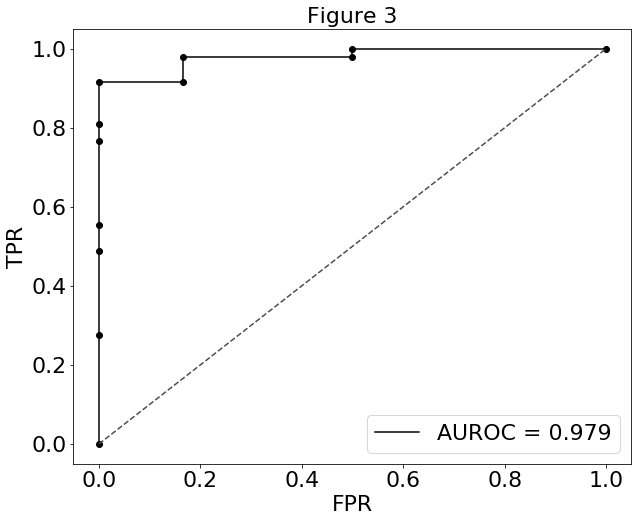

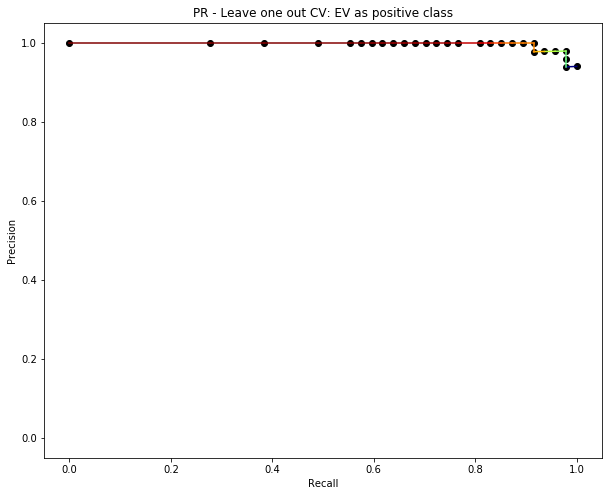

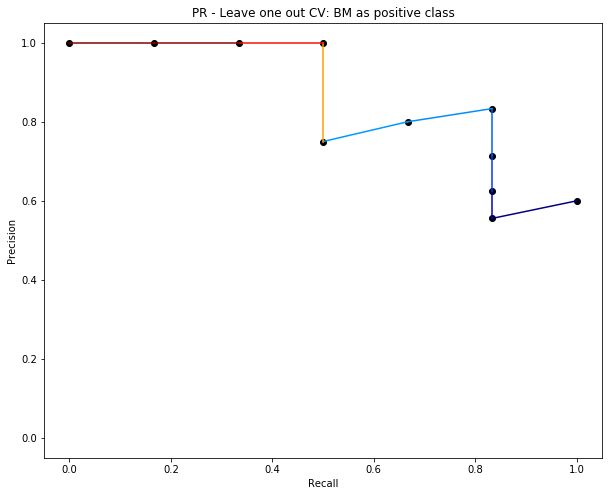

In [19]:
fpr, tpr, thres = roc_curve([0 if x == 'BM1_M' or x == 'BM2_M' else 1 for x in loo_class_label], 
                            loo_pos_class_proba)
fpr = np.insert(fpr, 0, 0)
tpr = np.insert(tpr, 0, 0)

auroc = roc_auc_score([0 if x == 'BM1_M' or x == 'BM2_M' else 1 for x in loo_class_label], loo_pos_class_proba)
fig, ax = plt.subplots(figsize=(10,8))
print(auroc)
ax.tick_params(axis='x', labelsize=22)
ax.tick_params(axis='y', labelsize=22)
plt.scatter(fpr, tpr, c='k')
plt.title('Figure 3', fontsize=22)
#plot_colourline(fpr, tpr, thres)
plt.plot(fpr, tpr, c='k', label='AUROC = {:.3f}'.format(auroc))
ax.plot([0, 1], [0, 1], ls="--", c=".3")
plt.legend(fontsize=22)
plt.xlabel('FPR', fontsize=22)
plt.ylabel('TPR', fontsize=22)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.savefig('{}/auc_lit.png'.format(loo_dir), dpi=600)
plt.savefig('../figures/fig3.png'.format(loo_dir), dpi=600)
plt.show()

precision, recall, thres = precision_recall_curve([0 if x == 'BM1_M' or x == 'BM2_M'  else 1 for x in loo_class_label],
                                                  loo_pos_class_proba)
plt.subplots(figsize=(10,8))
plt.scatter(recall, precision, c='k')
plt.title('PR - Leave one out CV: EV as positive class')
plot_colourline(recall, precision, thres)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.savefig('{}/pr_EV_pos_lit.png'.format(loo_dir), dpi=600)
plt.show()

precision, recall, thres = precision_recall_curve([0 if x == 'EV1_M' or x == 'EV2_M'  else 1 for x in loo_class_label],
                                                  [1-x for x in loo_pos_class_proba])
plt.subplots(figsize=(10,8))
plt.scatter(recall, precision, c='k')
plt.title('PR - Leave one out CV: BM as positive class')
plot_colourline(recall, precision, thres)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.savefig('{}/pr_BM_pos_lit.png'.format(loo_dir), dpi=600)
plt.show()